## assignment 04: Decision Tree construction

In [ ]:
# If working in colab, uncomment the following line
# ! wget https://raw.githubusercontent.com/girafe-ai/ml-course/22f_basic/homeworks/assignment0_04_tree/tree.py -nc

In [78]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.base import BaseEstimator
from sklearn.datasets import make_classification, make_regression, load_digits
#from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, mean_squared_error
import pandas as pd

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Let's fix the `random_state` (a.k.a. random seed).

In [115]:
RANDOM_STATE = 42

__Твоя главная задача на сегодня — реализовать класс `DecisionTree` и использовать его для решения задач классификации и регрессии.__  

__Технические характеристики:__  
- Класс наследуется от `sklearn.BaseEstimator`;  
- Конструктор уже реализован. Он имеет следующие параметры:  
    * `max_depth` — максимальная глубина дерева; по умолчанию `np.inf`;  
    * `min_samples_split` — минимальное количество объектов в листе для выполнения разбиения; по умолчанию `2`;  
    * `criterion` — критерий выбора наилучшего разбиения; в классификации — один из `['gini', 'entropy']`, по умолчанию `gini`; в регрессии — `variance`.  

- Метод `fit` принимает `X` (`numpy.array` типа `float` размерности `(n_objects, n_features)`) и `y` (`numpy.array` типа `float` размерности `(n_objects, 1)` в регрессии; `numpy.array` типа `int` размерности `(n_objects, 1)` с метками классов в классификации). Он работает **inplace** и обучает экземпляр класса `DecisionTree` с нуля на предоставленных данных.  

- Метод `predict` принимает `X` (`numpy.array` типа `float` размерности `(n_objects, n_features)`) и возвращает предсказанные значения $\hat{y}$. В классификации это метка класса для каждого объекта (наиболее часто встречающийся класс в листе; если несколько классов соответствуют этому критерию, выбирается класс с наименьшим индексом). В регрессии это предсказанное значение (например, среднее значение для критерия `variance`).  

- Метод `predict_proba` (работает только для классификации с критериями `gini` или `entropy`). Он принимает `X` (`numpy.array` типа `float` размерности `(n_objects, n_features)`) и возвращает `numpy.array` типа `float` размерности `(n_objects, n_features)` с вероятностями классов для каждого объекта из `X`. Вероятность класса $i$ равна отношению числа объектов класса $i$ в данном узле к числу объектов в обучающей выборке, попавших в этот узел.  

    
__Краткое напоминание:__  

Для поиска оптимального разбиения оценивается следующий функционал:  
    
$$G(j, t) = H(Q) - \dfrac{|L|}{|Q|} H(L) - \dfrac{|R|}{|Q|} H(R),$$  
где $Q$ — это набор данных текущего узла, $L$ и $R$ — левые и правые подмножества, определенные разбиением $x^{(j)} < t$.  

### 1. Классификация  
Пусть $p_i$ — вероятность класса $i$ в подмножестве $X$ (отношение числа объектов класса $i$ ко всему набору данных). Критерии определяются следующим образом:  

- **`gini`**: Индекс Джини  
  $$H(R) = 1 -\sum_{i = 1}^K p_i^2$$  

- **`entropy`**: Энтропия  
  $$H(R) = -\sum_{i = 1}^K p_i \log(p_i)$$  
  (Можно использовать натуральный логарифм).  

### 2. Регрессия  
Пусть $y_l$ — целевое значение для $R$, а $\mathbf{y} = (y_1, \dots, y_N)$ — все целевые значения для выбранного набора данных $X$.  

- **`variance`**:  
  $$H(R) = \dfrac{1}{|R|} \sum_{y_j \in R}(y_j - \text{mean}(\mathbf{y}))^2$$  

- **`mad_median`**:  
  $$H(R) = \dfrac{1}{|R|} \sum_{y_j \in R}|y_j - \text{median}(\mathbf{y})|$$

### **Подсказки и комментарии**:

* Не нужно обрабатывать категориальные признаки, их не будет в данных.  
* Простая жадная рекурсивная процедура будет достаточной. Однако можно ускорить её (например, используя перцентили).  
* Пожалуйста, не копируй готовые реализации из интернета. Твоя задача — создать очень простой пример дерева решений.

File `tree.py` is waiting for you. Implement all the needed methods in that file.

### Check yourself

In [146]:
from tree import entropy, gini, variance, mad_median, DecisionTree

#### Simple check

In [147]:
X = np.ones((4, 5), dtype=float) * np.arange(4)[:, None]
y = np.arange(4)[:, None] + np.asarray([0.2, -0.3, 0.1, 0.4])[:, None]
class_estimator = DecisionTree(max_depth=10, criterion_name='gini')

(X_l, y_l), (X_r, y_r) = class_estimator.make_split(1, 1., X, y)

assert np.array_equal(X[:1], X_l)
assert np.array_equal(X[1:], X_r)
assert np.array_equal(y[:1], y_l)
assert np.array_equal(y[1:], y_r)

#### Classification problem

In [148]:
digits_data = load_digits().data
digits_target = load_digits().target[:, None] # to make the targets consistent with our model interfaces
X_train, X_test, y_train, y_test = train_test_split(digits_data, digits_target, test_size=0.2, random_state=RANDOM_STATE)

In [149]:
assert len(y_train.shape) == 2 and y_train.shape[0] == len(X_train)

In [150]:
class_estimator = DecisionTree(max_depth=10, criterion_name='gini')
class_estimator.fit(X_train, y_train)
ans = class_estimator.predict(X_test)
accuracy_gini = accuracy_score(y_test, ans)
print(accuracy_gini)

0.8638888888888889


In [151]:
reference = np.array([0.09027778, 0.09236111, 0.08333333, 0.09583333, 0.11944444,
       0.13888889, 0.09930556, 0.09444444, 0.08055556, 0.10555556])

In [152]:
class_estimator = DecisionTree(max_depth=10, criterion_name='entropy')
class_estimator.fit(X_train, y_train)
ans = class_estimator.predict(X_test)
accuracy_entropy = accuracy_score(y_test, ans)
print(accuracy_entropy)

0.8805555555555555


In [153]:
proba = class_estimator.predict_proba(X_test)
mean_proba = proba.mean(axis=0)
print("Computed mean probabilities:", mean_proba)
print("Reference probabilities:", reference)

Computed mean probabilities: [0.08611111 0.09236111 0.08194444 0.09166667 0.11666667 0.13888889
 0.10347222 0.1        0.08333333 0.10555556]
Reference probabilities: [0.09027778 0.09236111 0.08333333 0.09583333 0.11944444 0.13888889
 0.09930556 0.09444444 0.08055556 0.10555556]


In [154]:
unique_classes, counts = np.unique(y_test, return_counts=True)
class_distribution = counts / len(y_test)
print("Class distribution in test set:", class_distribution)

Class distribution in test set: [0.09166667 0.07777778 0.09166667 0.09444444 0.12777778 0.13055556
 0.09722222 0.09444444 0.08333333 0.11111111]


In [155]:
assert  0.84 < accuracy_gini < 0.9
assert  0.86 < accuracy_entropy < 0.9
assert np.sum(np.abs(class_estimator.predict_proba(X_test).mean(axis=0) - reference)) < 1e-4

AssertionError: 

Let's use 5-fold cross validation (`GridSearchCV`) to find optimal values for `max_depth` and `criterion` hyperparameters.

In [98]:
param_grid = {'max_depth': range(3,11), 'criterion_name': ['gini', 'entropy']}
gs = GridSearchCV(DecisionTree(), param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-2)

In [99]:
%%time
gs.fit(X_train, y_train)

CPU times: total: 3.86 s
Wall time: 31 s


GridSearchCV(cv=5, estimator=DecisionTree(), n_jobs=-2,
             param_grid={'criterion_name': ['gini', 'entropy'],
                         'max_depth': range(3, 11)},
             scoring='accuracy')

In [100]:
gs.best_params_

{'criterion_name': 'entropy', 'max_depth': 8}

In [101]:
assert gs.best_params_['criterion_name'] == 'entropy'
assert 6 < gs.best_params_['max_depth'] < 9

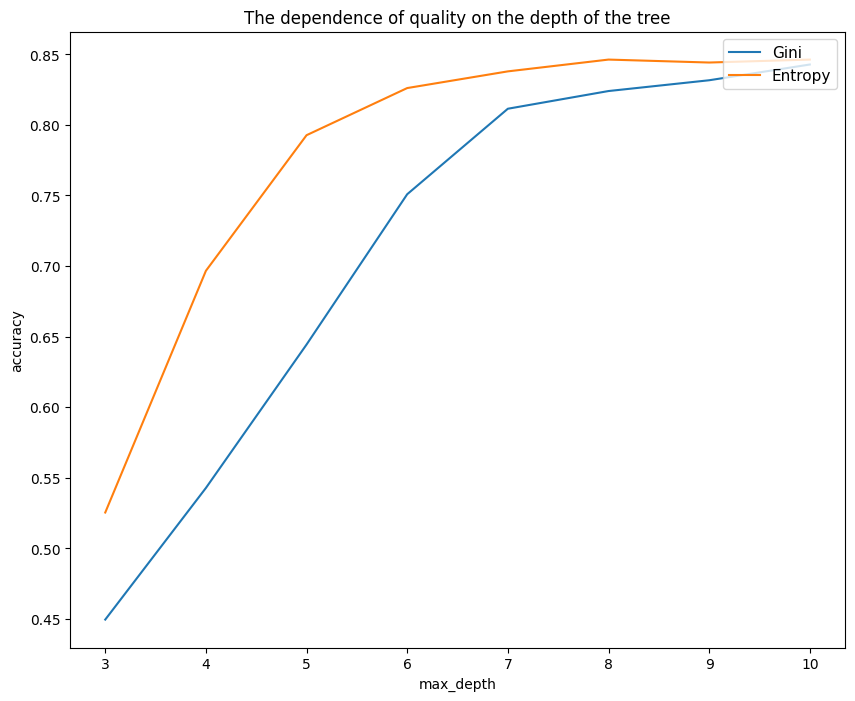

In [102]:
plt.figure(figsize=(10, 8))
plt.title("The dependence of quality on the depth of the tree")
plt.plot(np.arange(3,11), gs.cv_results_['mean_test_score'][:8], label='Gini')
plt.plot(np.arange(3,11), gs.cv_results_['mean_test_score'][8:], label='Entropy')
plt.legend(fontsize=11, loc=1)
plt.xlabel("max_depth")
plt.ylabel('accuracy')
plt.show()

#### Regression problem

In [169]:
from sklearn.datasets import fetch_openml

boston = fetch_openml(name="boston", version=1, as_frame=False)
regr_data = boston.data
regr_target = boston.target[:, None] 
RX_train, RX_test, Ry_train, Ry_test = train_test_split(regr_data, regr_target, test_size=0.2, random_state=RANDOM_STATE)

In [170]:
regressor = DecisionTree(max_depth=10, criterion_name='mad_median')
regressor.fit(RX_train, Ry_train)
predictions_mad = regressor.predict(RX_test)
mse_mad = mean_squared_error(Ry_test, predictions_mad)
print(mse_mad)

64.72431372549019


In [171]:
regressor = DecisionTree(max_depth=10, criterion_name='variance')
regressor.fit(RX_train, Ry_train)
predictions_mad = regressor.predict(RX_test)
mse_var = mean_squared_error(Ry_test, predictions_mad)
print(mse_var)

85.28232160624648


In [172]:
assert 9 < mse_mad < 20
assert 8 < mse_var < 12

AssertionError: 

In [160]:
param_grid_R = {'max_depth': range(2,9), 'criterion_name': ['variance', 'mad_median']}

In [161]:
gs_R = GridSearchCV(DecisionTree(), param_grid=param_grid_R, cv=5, scoring='neg_mean_squared_error', n_jobs=-2)
gs_R.fit(RX_train, Ry_train)

GridSearchCV(cv=5, estimator=DecisionTree(), n_jobs=-2,
             param_grid={'criterion_name': ['variance', 'mad_median'],
                         'max_depth': range(2, 9)},
             scoring='neg_mean_squared_error')

In [162]:
gs_R.best_params_

{'criterion_name': 'mad_median', 'max_depth': 4}

In [163]:
assert gs_R.best_params_['criterion_name'] == 'mad_median'
assert 3 < gs_R.best_params_['max_depth'] < 7

In [164]:
var_scores = gs_R.cv_results_['mean_test_score'][:7]
mad_scores = gs_R.cv_results_['mean_test_score'][7:]

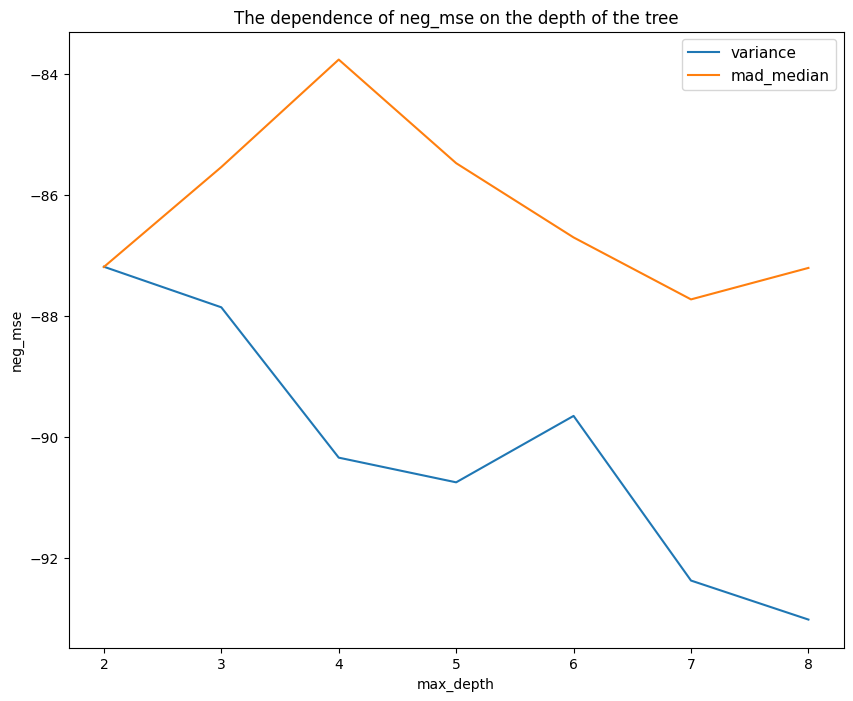

In [165]:
plt.figure(figsize=(10, 8))
plt.title("The dependence of neg_mse on the depth of the tree")
plt.plot(np.arange(2,9), var_scores, label='variance')
plt.plot(np.arange(2,9), mad_scores, label='mad_median')
plt.legend(fontsize=11, loc=1)
plt.xlabel("max_depth")
plt.ylabel('neg_mse')
plt.show()